# Predicting Heart Disease Through Classification with Health Indicators

Yiyao Ru, 
Liam Sissons,
Nizel Abalos,
Sebastian Yeo

## 1. Introduction

   Heart disease refers to a varying number of heart related conditions that may include arrhythmias, heart attack, or even heart failure. There are several risk factors that may contribute to the development of heart disease including unhealthy lifestyle, genetics, smoking, and more. In particular, high blood pressure and high cholesterol are main factors that may contribute to the development of heart disease (About heart disease 2022).  
   
   Using the “Heart Disease Data Set” from UCI’s Machine Learning Repository, this data analysis explores the relationship between heart disease and health variables including: age, chest pain, exercise induced angina, maximum heart rate achieved, vessels coloured by fluoroscopy, resting ECG measurements, sex, slope of peak exercise in ST segment, resting/exercise induced ST depression and thalassemia using a classification model. These variables were chosen based on exploration of their relationships with heart disease risk through visualizations. The variables that showed a trend in relation to heart disease risk were chosen for the classification. The specific data set from Cleveland was chosen due to the prevalence of heart disease related to lifestyle and health factors in the United States (U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? 2020). The data set includes health related test results collected from about 300 patients in Cleveland and originates from the Cleveland Clinic Foundation. 
   
   In terms of the variables used, age relates to years lived, chest pain rates pain on a scale, and angina is exercised induced chest pain. Maximum heart rate looks at how high of a heart rate an individual can achieve, usually through exercise, and may indicate heart fitness. Other variables include results from fluoroscopy and ECGs. For instance, ST depression describes an abnormally low portion of the ST segment (area between QRS complex and T wave) on an electrocardiogram (ECG) reading (Rowden, 2022). ST depression may indicate several heart related health conditions. Finally, thalassemia is an inherited blood disorder.
   
   A classification model will be created which will classify the chosen variables and be used to predict heart disease risk. The data analysis and classification should help to answer the question: To what extent can the risk level of heart disease (no risk, low risk, or high risk) be predicted using the collected Cleveland data on the selected health variables?



## 2. Methods and Results

### 2.1 Reading the data

Required libraries are loaded below.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

The "Heart Disease Data Set" from the UCI Machine Learning Repository is read in as a csv file using the appropriate read function.

In [2]:
processed_cleveland_hd <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2.2 Preliminary Data Analysis

Column names are assigned to the unnamed columns based on those given by the UCI Machine Learning Repository and the data set is displayed in Table 1. Some of the column names are slightly modified to be more human readable. The first 6 rows of the data are printed.

In [3]:
colnames(processed_cleveland_hd) <- c("age", "sex", "chestpain", "rest_bloodpressure", "chol", "fast_sugar", "restecg", "maxhr", "ex_angina", "st_depression", "slope", "num_vessels", "thal", "num")
head(processed_cleveland_hd)

age,sex,chestpain,rest_bloodpressure,chol,fast_sugar,restecg,maxhr,ex_angina,st_depression,slope,num_vessels,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


_Table 1: Read Data_

The original data assigned risk levels from 0-4 based on risk level, with 0 being no indication of heart disease, and 4 being high risk. The risk categories of the data set were mutated into three categories: no risk (0), low risk (1-2) and high risk (3-4). This was done to reduce the amount of risk categories (5 being too many) and to make these numbered risk levels easier to understand. The risk level was also mutated to be a factor and is displayed in the table below. In addition, some observations did not have any value for the num_vessels and thal variables and were removed from the data set. Again, the first 6 rows are printed

In [4]:
hd_selected <- processed_cleveland_hd |>
    mutate(risk = ifelse(num == 0, "No Risk", ifelse(num >= 3, "High Risk", "Low Risk"))) |>
    select(-num) |>
    mutate(risk = as_factor(risk), num_vessels = as.double(num_vessels), thal = as.double(thal)) |>
    filter(!is.na(num_vessels)) |>
    filter(!is.na(thal))
head(hd_selected)

Warning message:
"There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `num_vessels = as.double(num_vessels)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."


age,sex,chestpain,rest_bloodpressure,chol,fast_sugar,restecg,maxhr,ex_angina,st_depression,slope,num_vessels,thal,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,No Risk
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Low Risk
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Low Risk
37,1,3,130,250,0,0,187,0,3.5,3,0,3,No Risk
41,0,2,130,204,0,2,172,0,1.4,1,0,3,No Risk
56,1,2,120,236,0,0,178,0,0.8,1,0,3,No Risk


_Table 2: Cleaned Data_

The data is split into two groups: training and testing. Strata is assigned to be risk, which is what will be predicted. The split uses 75% of the data for training and 25% of the data for testing. The training data will be used to train the model. The model will then be tested on the testing data.

In [5]:

set.seed(1234)

hd_split <- initial_split(hd_selected, prop = 0.75, strata = risk)
hd_train <- training(hd_split)
hd_test <- testing(hd_split)

Data exploration is done to determine which variables will be the best for the classification model. The average values for each risk level are tabulated in order to better understand the distribution of points within each category.

In [6]:
hd_predictors_train <- hd_train |>
    group_by(risk) |>
    summarize(across(age:thal, mean))|>
    arrange(risk)

hd_observations <- hd_train |>
    group_by(risk) |>
    summarise(count = n())

hd <- merge(hd_predictors_train, hd_observations, on = "risk")

distinct(hd)

risk,age,sex,chestpain,rest_bloodpressure,chol,fast_sugar,restecg,maxhr,ex_angina,st_depression,slope,num_vessels,thal,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
High Risk,56.44444,0.8611111,3.694444,135.4444,243.4444,0.1666667,1.3055556,132.5278,0.6111111,2.0416667,2.027778,1.5000000,6.138889,36
Low Risk,57.03030,0.8181818,3.545455,134.6970,255.2727,0.1212121,1.0757576,139.5909,0.5151515,1.3924242,1.712121,0.9848485,5.560606,66
No Risk,52.33333,0.5583333,2.783333,129.2000,243.8667,0.1500000,0.8416667,158.8500,0.1416667,0.5466667,1.391667,0.2833333,3.866667,120


_Table 3: Data Means Explored_

Some of the mean values for each variable differ, but that does not show how the distributions in each risk level looks like. Visualization can help demonstrate the correlation of each variable and their risk level.

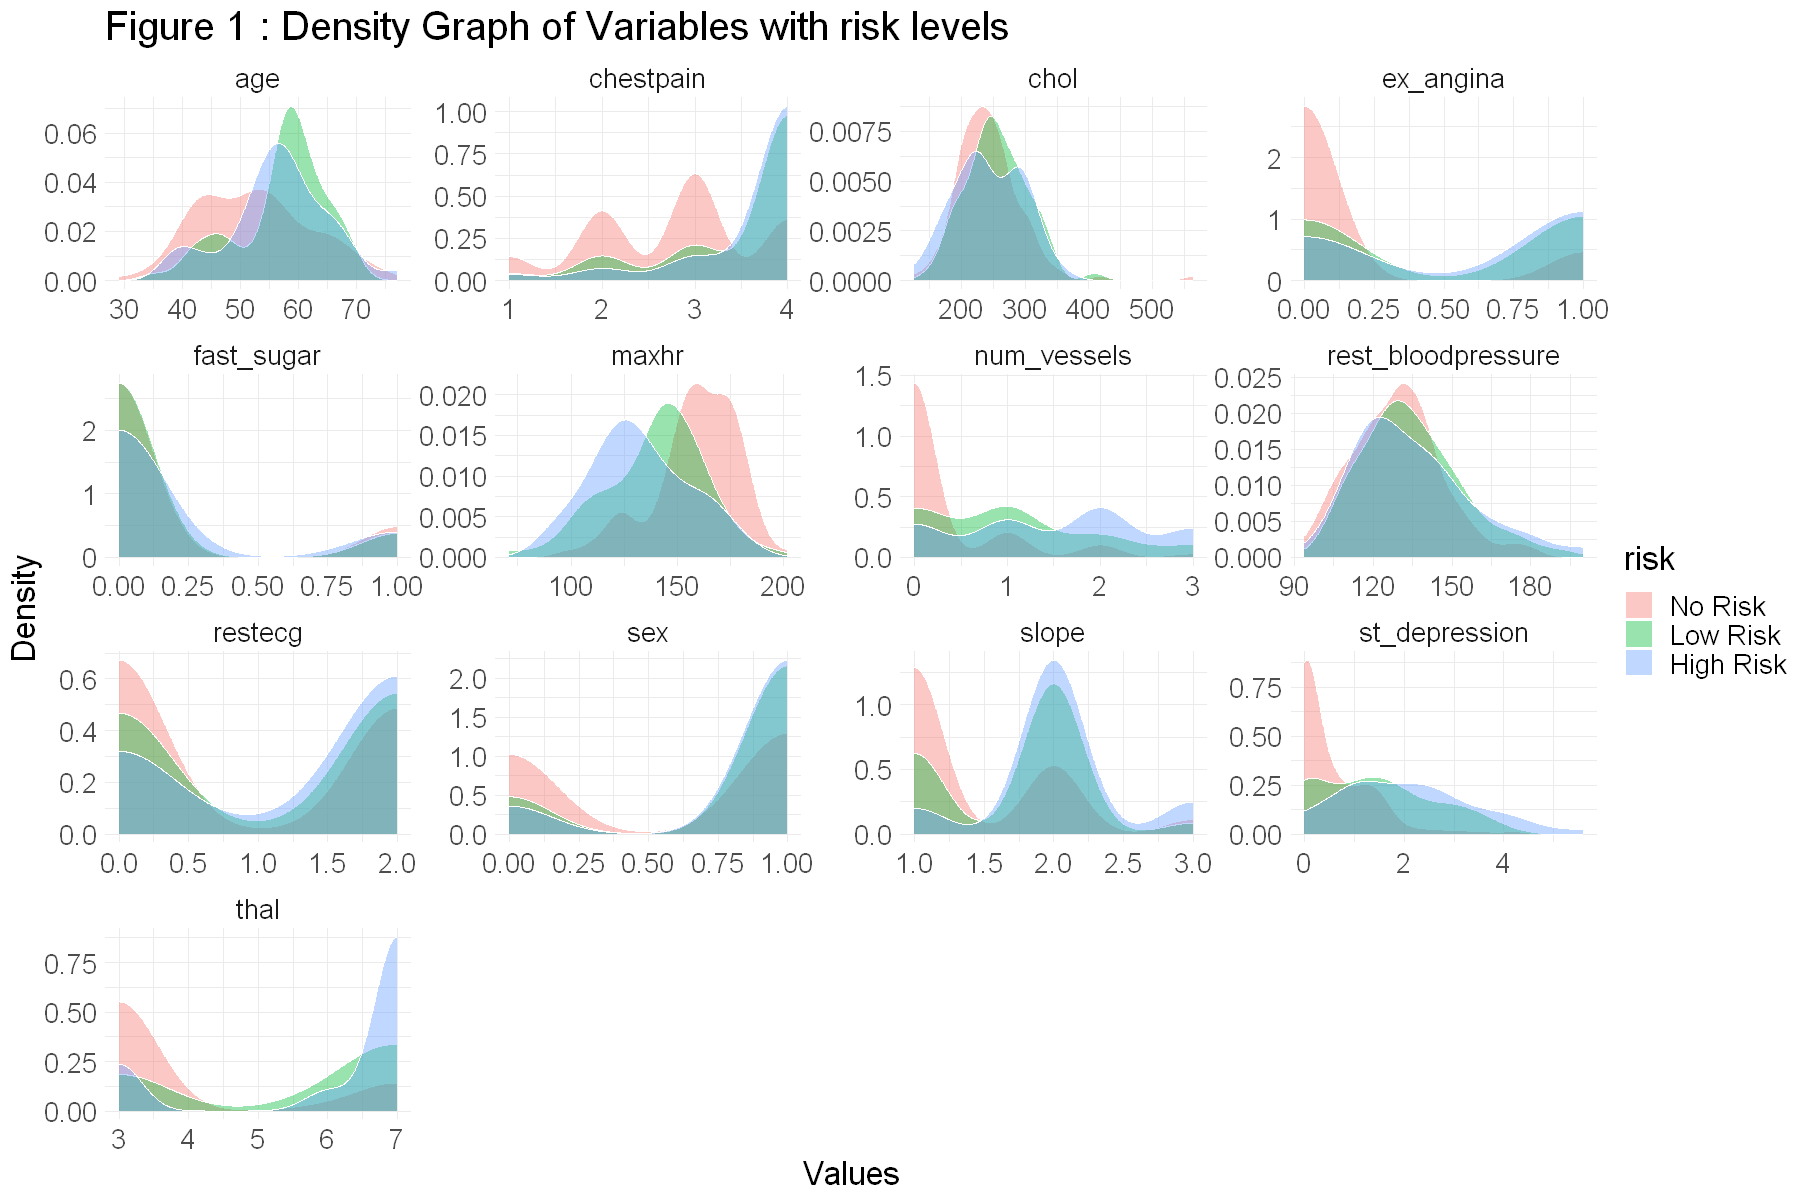

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10)
hd_plot <- hd_train |>
    pivot_longer(cols = -risk, names_to = "category", values_to = "value") |>
    ggplot(aes(value, fill = risk)) +
    geom_density(alpha = 0.4, colour = "white") +
    facet_wrap(facets = vars(category), scales = "free") +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 1 : Density Graph of Variables with risk levels") +
    labs(x = "Values", y = "Density")
hd_plot

From Table 3 and Figure 1, we can determine that variables that have little to no correlation are cholesterol levels (chol), fasting blood sugar being greater than 120 mg (fast_sugar), and resting blood pressure (rest_bloodpressure). The other variables show distinct distributions for the level of risks and can be used to train the model. For example, the chest pain levels are lower for those that do not have any risk in heart disease, while it is higher for those that do have a risk of heart disease. Looking at the mean levels of chest pain for each risk category, the ones with low or high risk have a higher level than those with no risk. Similar analysis was done to the other variables, so the variables chosen to train the model were age (age), level of chest pain (chestpain), exercise induced angina (ex_angina), max heart rate achieved (maxhr), number of major vessels colored by fluoroscopy (num_vessels), resting ECG results (restecg), sex (sex), the slope of the peak exercise ST segment (slope), ST depression induced by exercise relative to rest (st_depression), and the type of thalassemia (thal). 

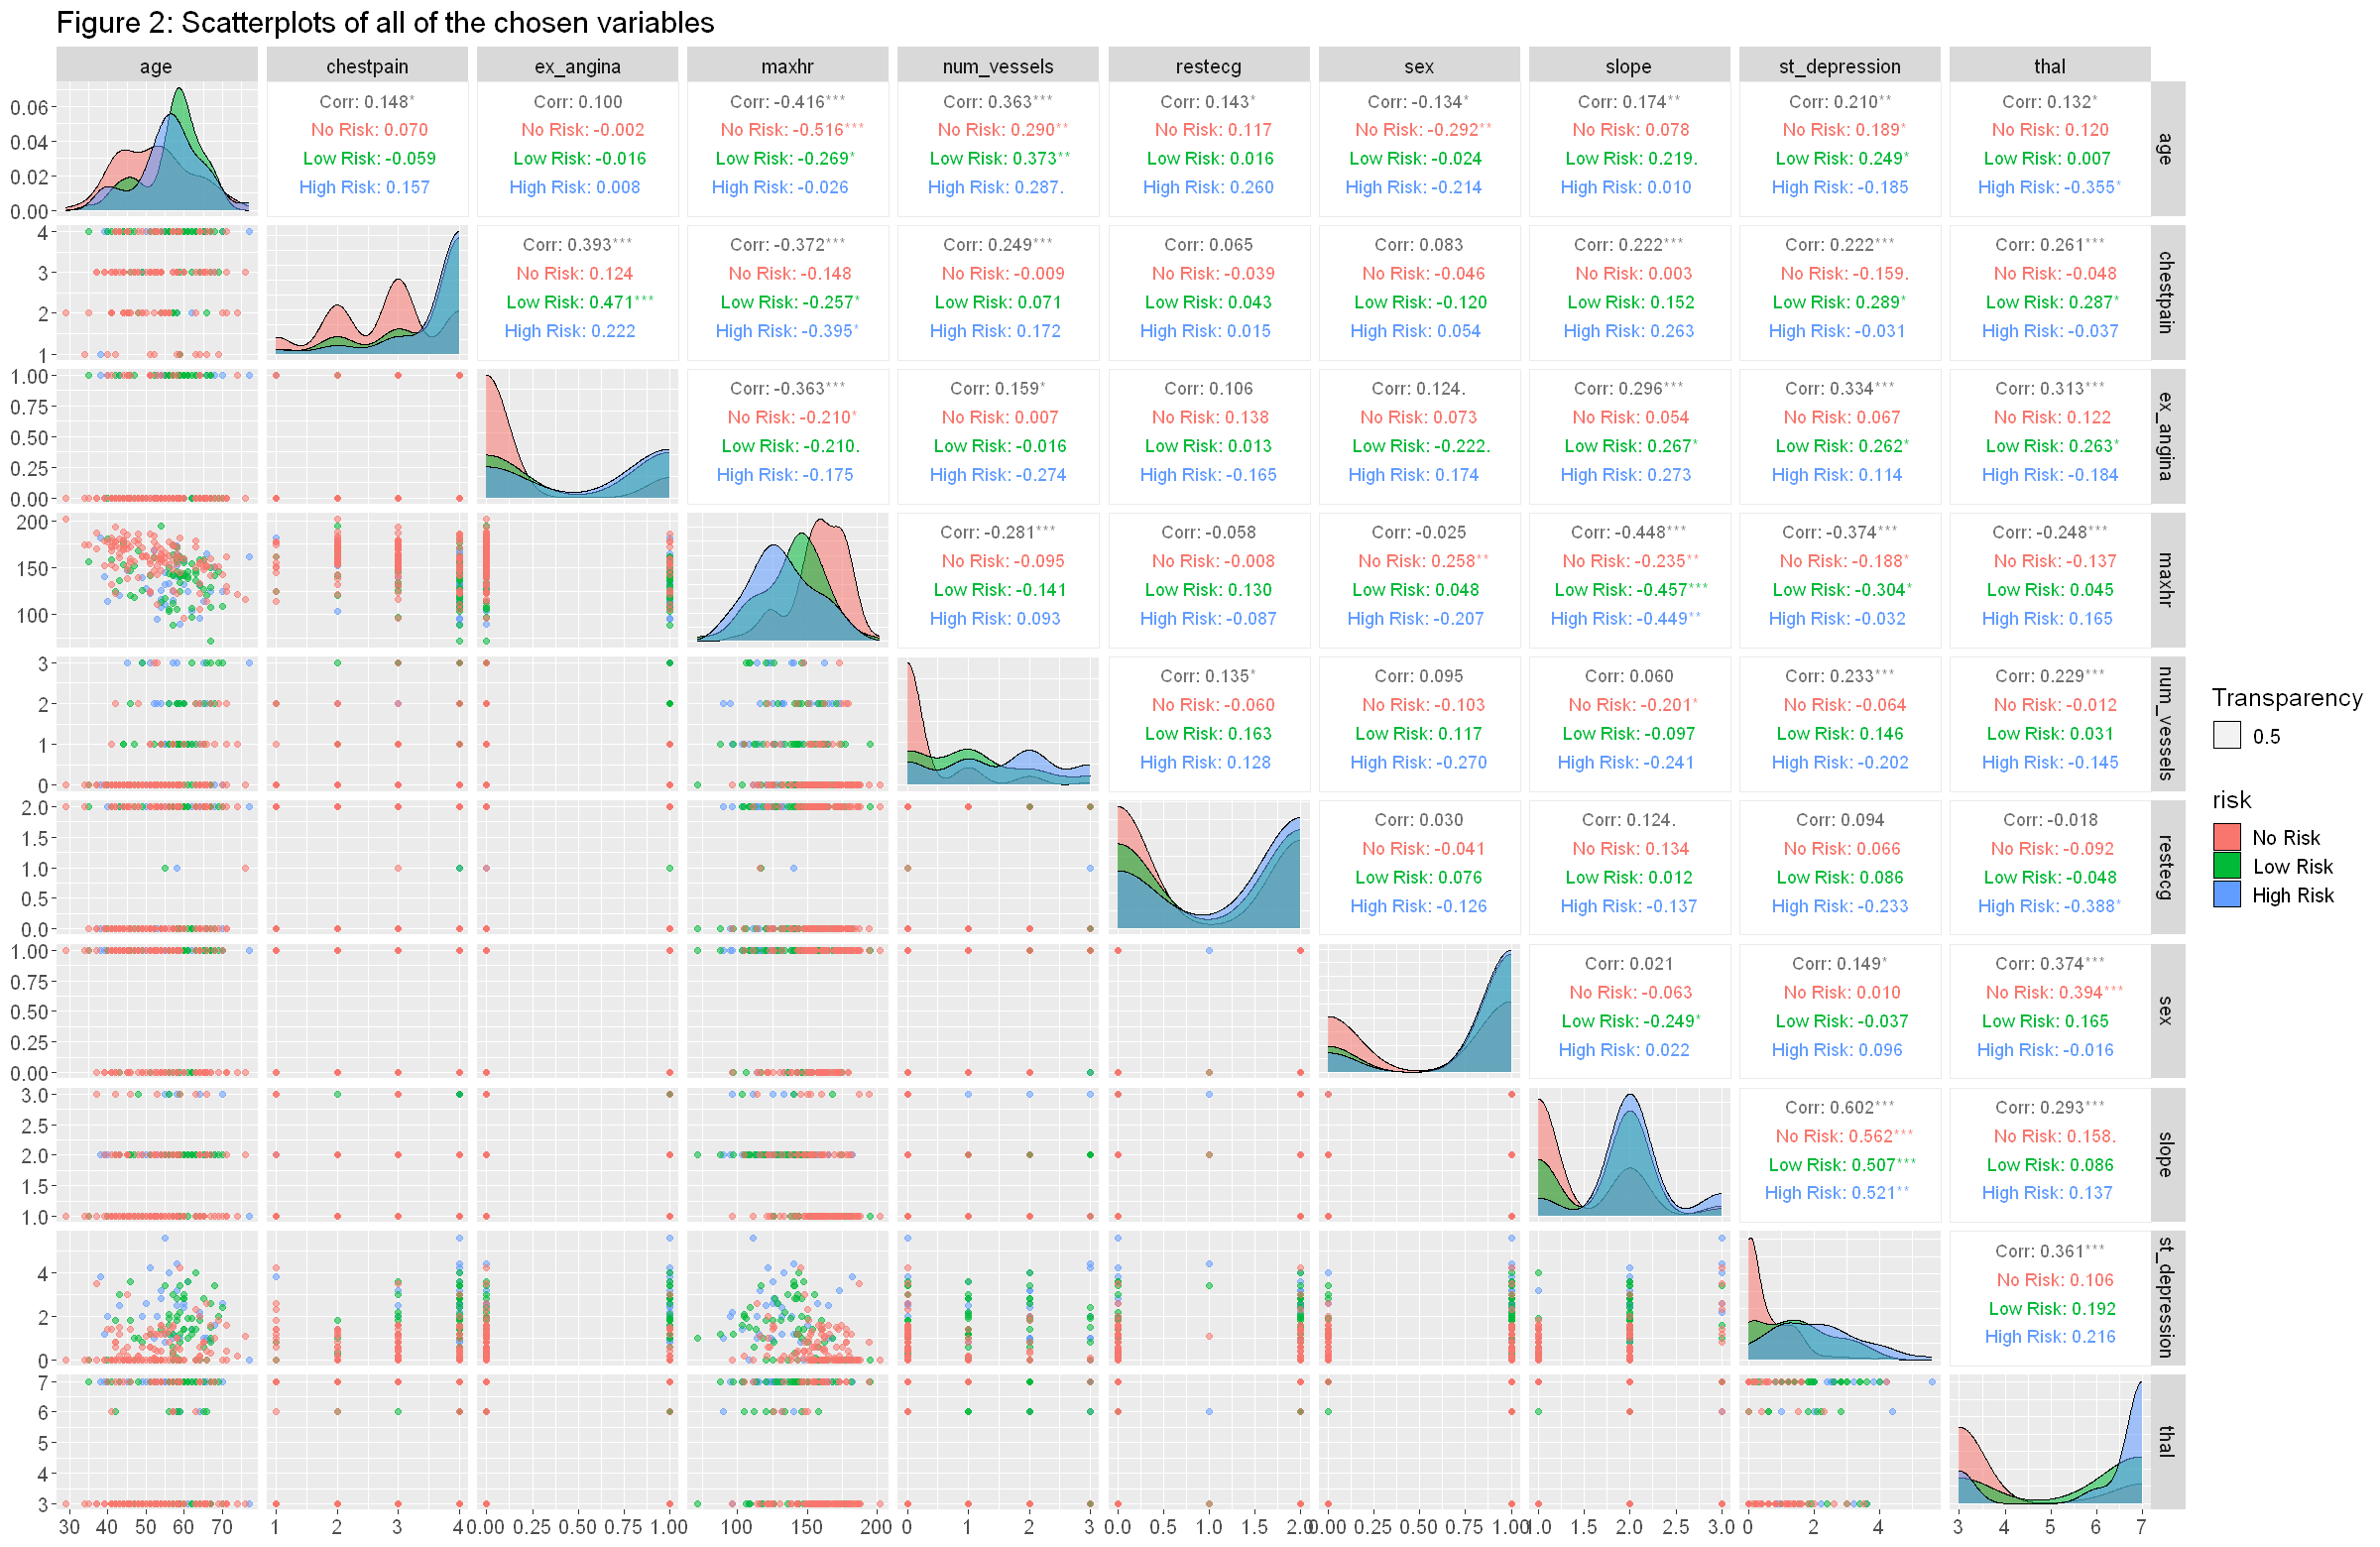

In [8]:
options(repr.plot.width = 20, repr.plot.height = 13)
hd_pairs <- hd_train |>
    select(age, chestpain, ex_angina, maxhr, num_vessels, restecg, sex, slope, st_depression, thal, risk) |>
    ggpairs(columns = 1:10, aes(color = risk, alpha = 0.5), legend = c(1, 1)) +
    labs(alpha = "Transparency", color = "Risk") +
    theme(legend.position = "right", text = element_text(size =15)) +
    ggtitle("Figure 2: Scatterplots of all of the chosen variables")
hd_pairs

Looking at the scatterplots from Figure 2, the "grouping" or clustering of the risk groups can be seen in the selected variables, which further show that they are variables that can train the model. That being said, the highest amount of clustering were observed in the maxhr vs st_depression and slope vs st_depression plots which will be used to determine if the model is classifying the test set accurately.

### 2.3 Building the Model

The classification model is created below. A recipe assigns risk as a combination of the selected variables (age, chest pain, exercise induced angina, vessels coloured by fluoroscopy, resting ECG, sex, slope, ST depression and thalassemia) and the predictors are all scaled. Since the value of K might influence the accuracy of the model, various values of K are tested to determine the optimal K value using cross validation. 10 folds were used in the cross validation because that value produced the most precise results (less variation in K values). Finally, we filter for accuracy.

In [10]:
set.seed(2023)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
hd_recipe <- recipe(risk ~ age + chestpain + ex_angina + num_vessels + restecg + sex + slope + st_depression + thal, data = hd_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
hd_vfold <- vfold_cv(hd_train, v = 10, strata = risk)
hd_tune <- workflow() |>
                  add_recipe(hd_recipe) |>
                  add_model(knn_tune) |>
                  tune_grid(resamples = hd_vfold, grid=k_vals) |>
                  collect_metrics()
hd_accuracies <- hd_tune |>
    filter(.metric == "accuracy")

A visualization of neighbors vs. accuracy estimate is produced in Figure 2 to identify the best K value. From the graph, the highest accuracy (about 69%) is acheived by a K value of 41.

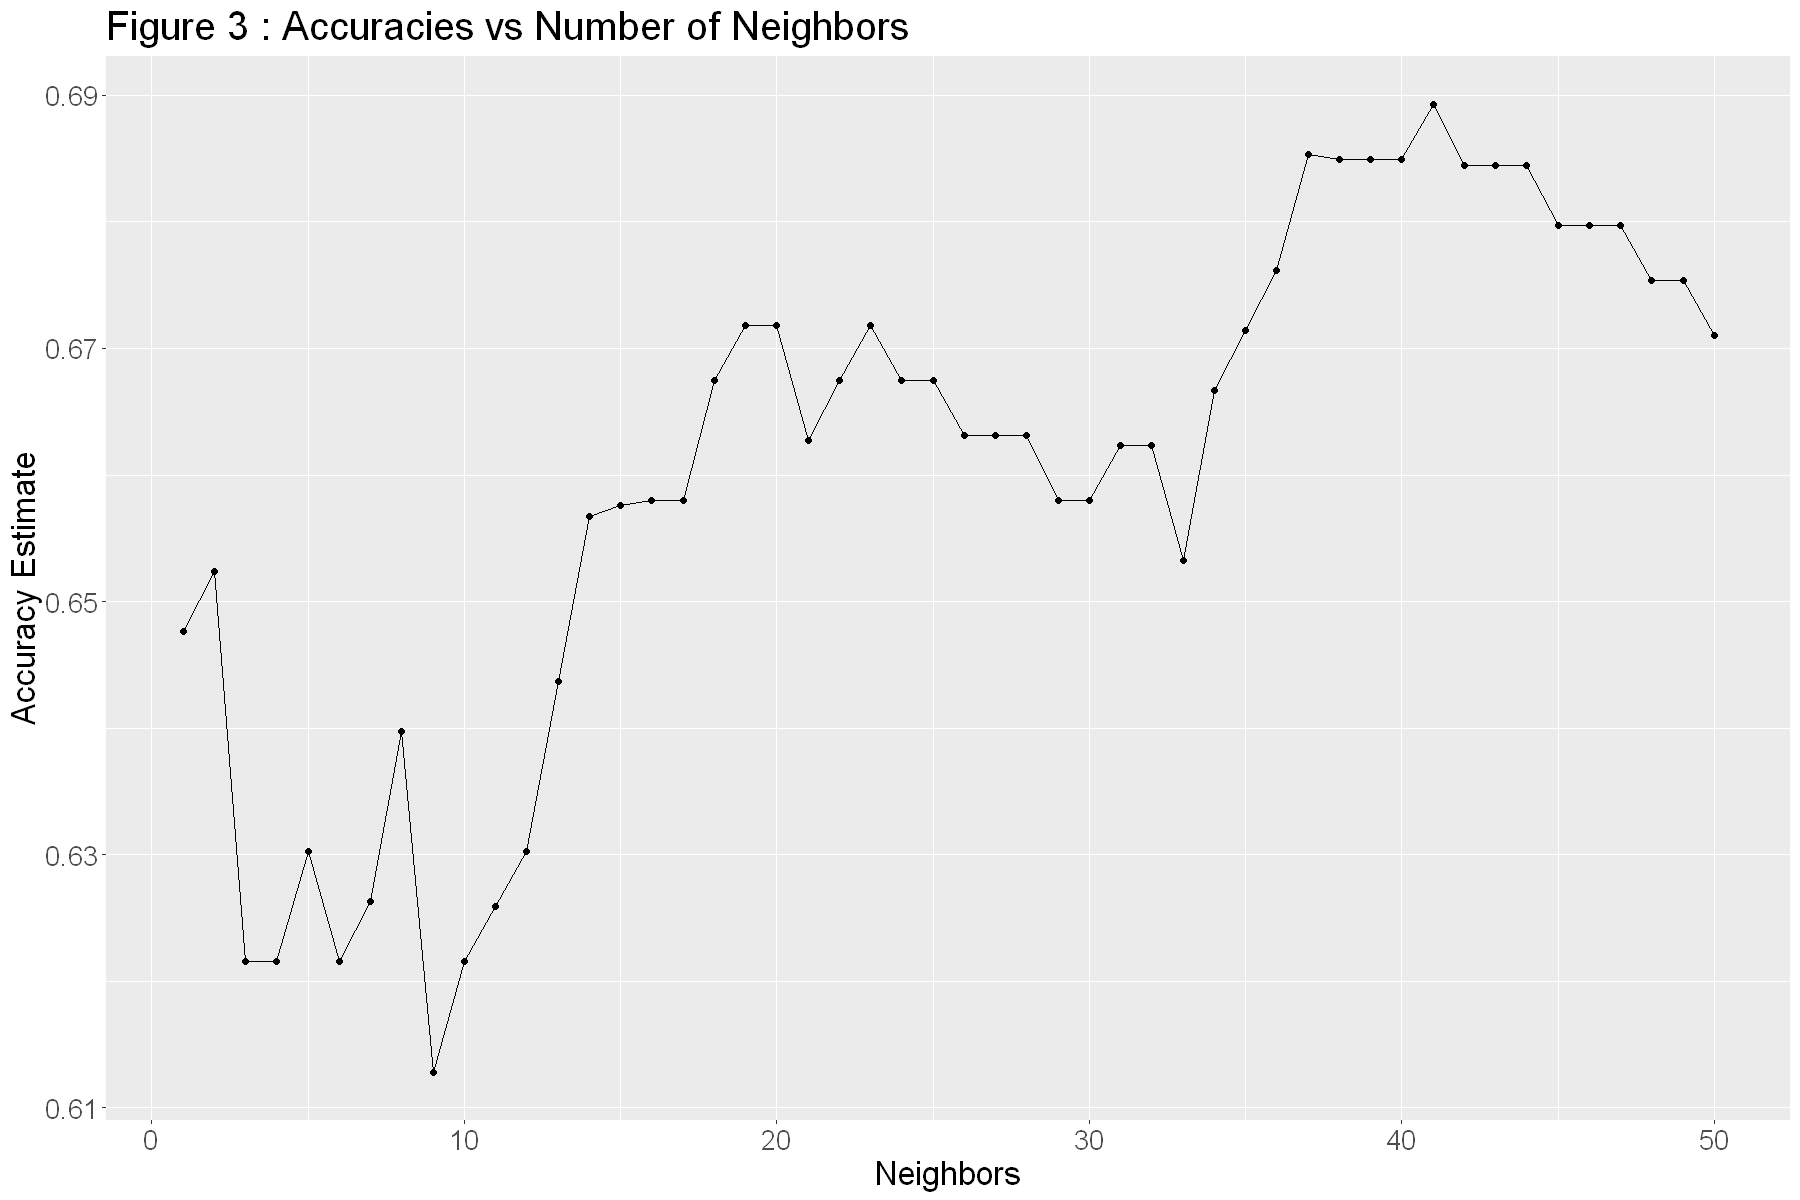

In [11]:
options(repr.plot.width = 15, repr.plot.height = 10)
knn_plot <- ggplot(hd_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 20)) +
  ggtitle("Figure 3 : Accuracies vs Number of Neighbors")
knn_plot

Using the best K value which was obtained above, the classification model is trained. Then, the predict function is used and the overall accuracy is displayed. As shown in Table 4 the K value of 41 has an accuracy of 68% with the testing set.

In [12]:
k_selected <- hd_accuracies |>
    arrange(desc(mean)) |>
    slice(1) |>
    select(neighbors) |>
    pull()
k_selected
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = k_selected) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_fit <- workflow() |>
    add_recipe(hd_recipe) |>
    add_model(knn_spec) |>
    fit(data = hd_train)
hd_predictions <- predict(knn_fit, hd_test) |>
  bind_cols(hd_test)
hd_predictions |>
  metrics(truth = risk, estimate = .pred_class) |>
  filter(.metric == "accuracy")

[1] 41

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.68


_Table 4: Accuracy of Classification Model_

A confusion matrix was created to look at the model's predictions. The model did not identify any points in the high risk category correctly, but it shows a general prediction ability for the other categories.

In [13]:
heart_conf_mat <- hd_predictions |>
conf_mat(truth = risk, estimate = .pred_class)
heart_conf_mat

           Truth
Prediction  No Risk Low Risk High Risk
  No Risk        39       11         1
  Low Risk        1       12        11
  High Risk       0        0         0

_Table 5: Confusion Matrix for Classification Model_

## 3. Discussion

 Using a KNN classification model, it was possible to use the selected health variables (age, chest pain, exercise induced angina, maximum heart rate achieved, vessels coloured by fluoroscopy, resting ECG measurements, sex, slope of peak exercise in ST segment, resting/exercise induced ST depression and thalassemia) to predict heart disease risk within some degree of accuracy. Using cross-validation, the best K value was identified to be 41. The classification model predicted risk levels (zero, low, high) at an accuracy rate of 68%. This indicates that the classification of the chosen variables can be used to predict heart disease risk, but not to a high degree of accuracy. We expected there to be a fairly low accuracy because the factors chosen were only few from the many factors that can contribute to heart disease, and therefore would not predict risk with a high accuracy.
 
 Upon examining the confusion matrix, it appears that the classification model does not produce completely inaccurate predictions, but many of its predictions are not correct. The model did not predict any data points from the high risk category correctly. The majority of high risk points were classified as low risk. The model did, however, classify low risk points to a high degree of accuracy. Low risk points were classified half as no risk, and half as low. Overall, the model was not very accurate classifying the presence of heart disease, but could classify no heart disease quite accurately. There was a large difference in the amount of low risk samples compared to high risk samples which may have led to the decreased accuracy. Since there were not many data points for high risk patients, the model may not have been able to be trained with a high degree of accuracy for that category.
 


In Figures 4 and 5, we create visualizations to show the actual risk level vs. the predicted risk for several different variables to further explore what we saw in Table 5. 

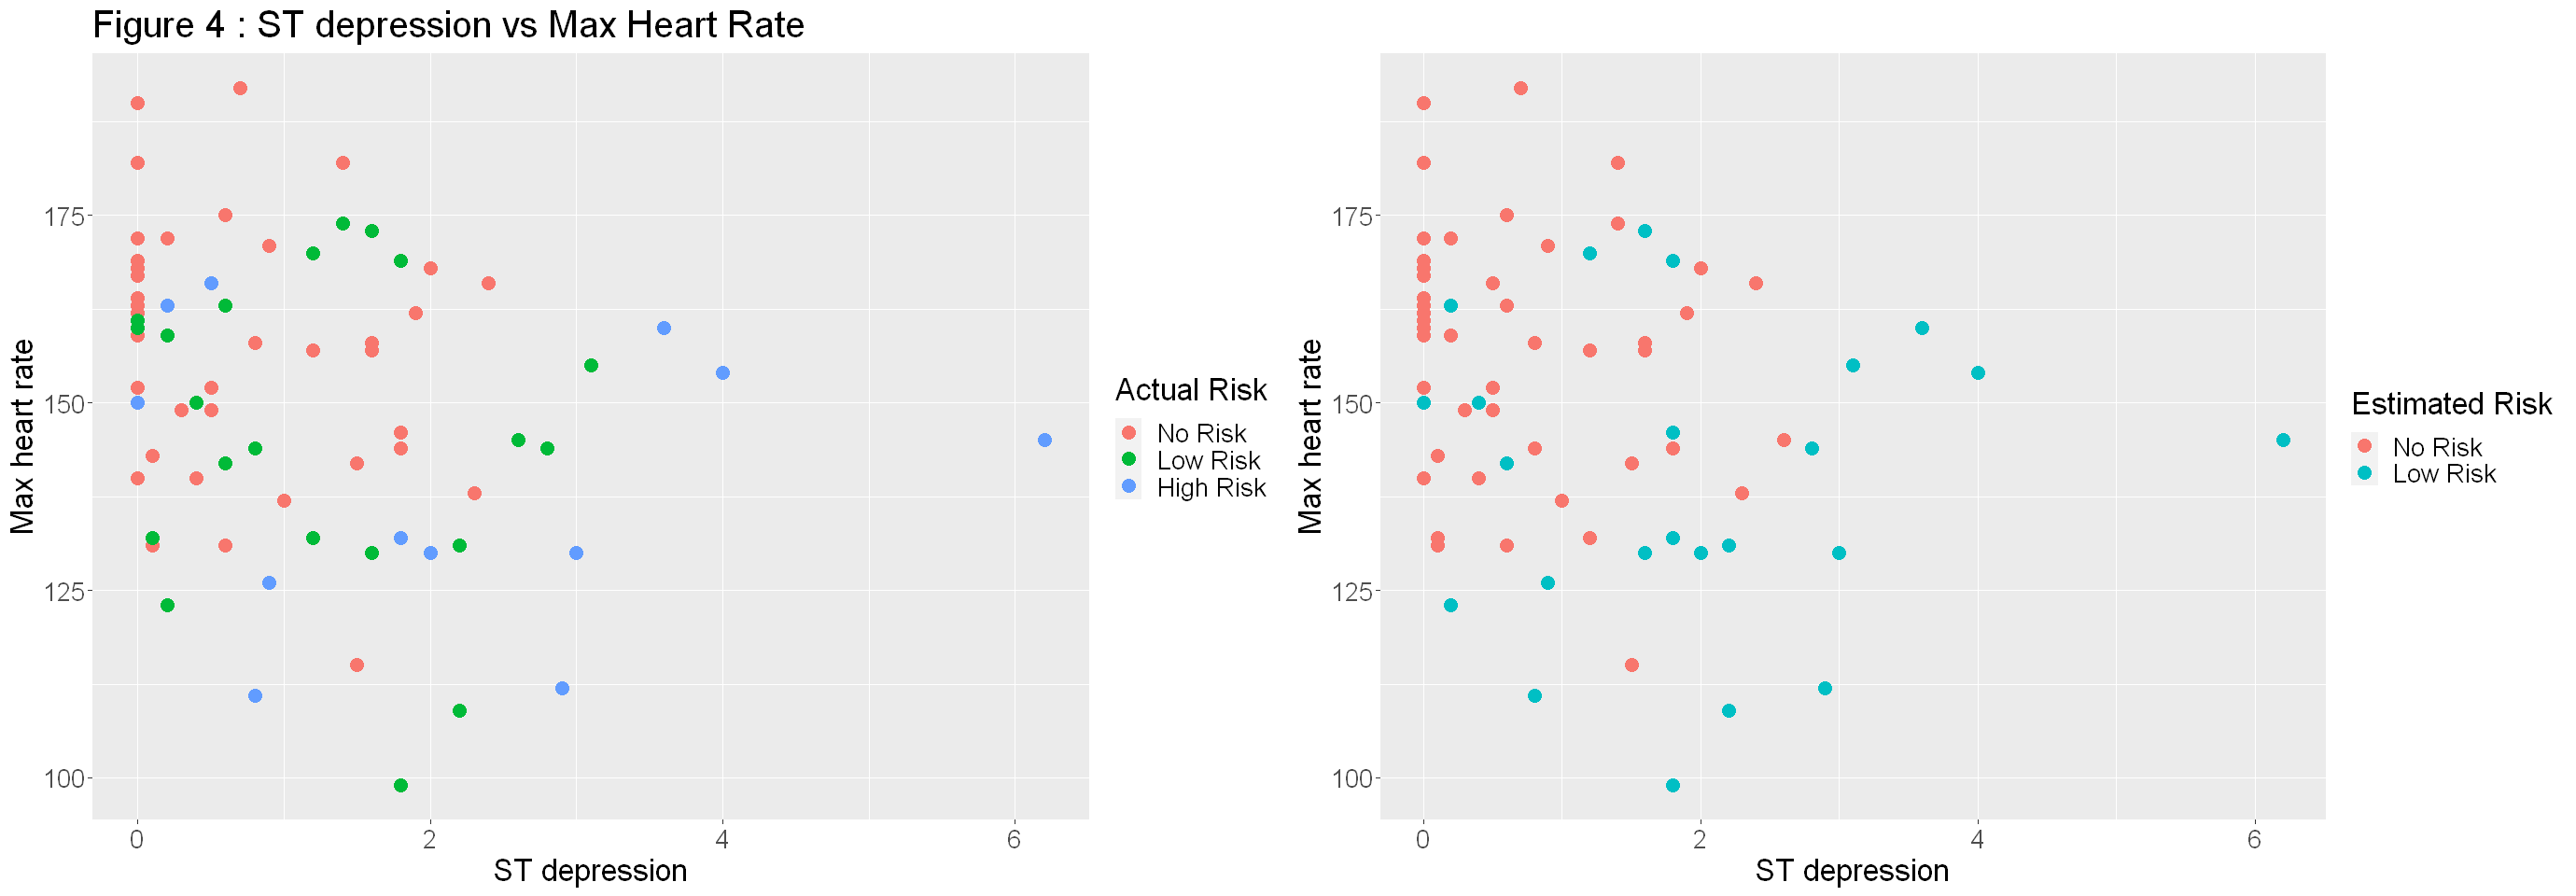

In [24]:
options(repr.plot.width = 23, repr.plot.height = 8)
hd_pred_truth_hrst <- hd_predictions |>
    ggplot(aes(x = st_depression, y = maxhr, color = risk)) +
    geom_point(size = 4) +
    labs(x = "ST depression", y = "Max heart rate", color = "Actual Risk") +
    ggtitle("Figure 4 : ST depression vs Max Heart Rate") +
    theme(text = element_text(size = 20))

hd_pred_estimate_hrst <- hd_predictions |>
    ggplot(aes(x = st_depression, y = maxhr, color = .pred_class)) +
    geom_point(size = 4) +
    labs(x = "ST depression", y = "Max heart rate", color = "Estimated Risk") +
    ggtitle("") +
    theme(text = element_text(size = 20))

plot_grid(hd_pred_truth_hrst, hd_pred_estimate_hrst)

Figure 4 demonstrates that the model can not predict any patients with high risk. It should also be noted that the high risk points are mostly found around points that are low, or no risk. This would make it difficult for a nearest neighbors model to classify them correctly since they appear to fit values for low, or no risk (by looking at the neighbors).

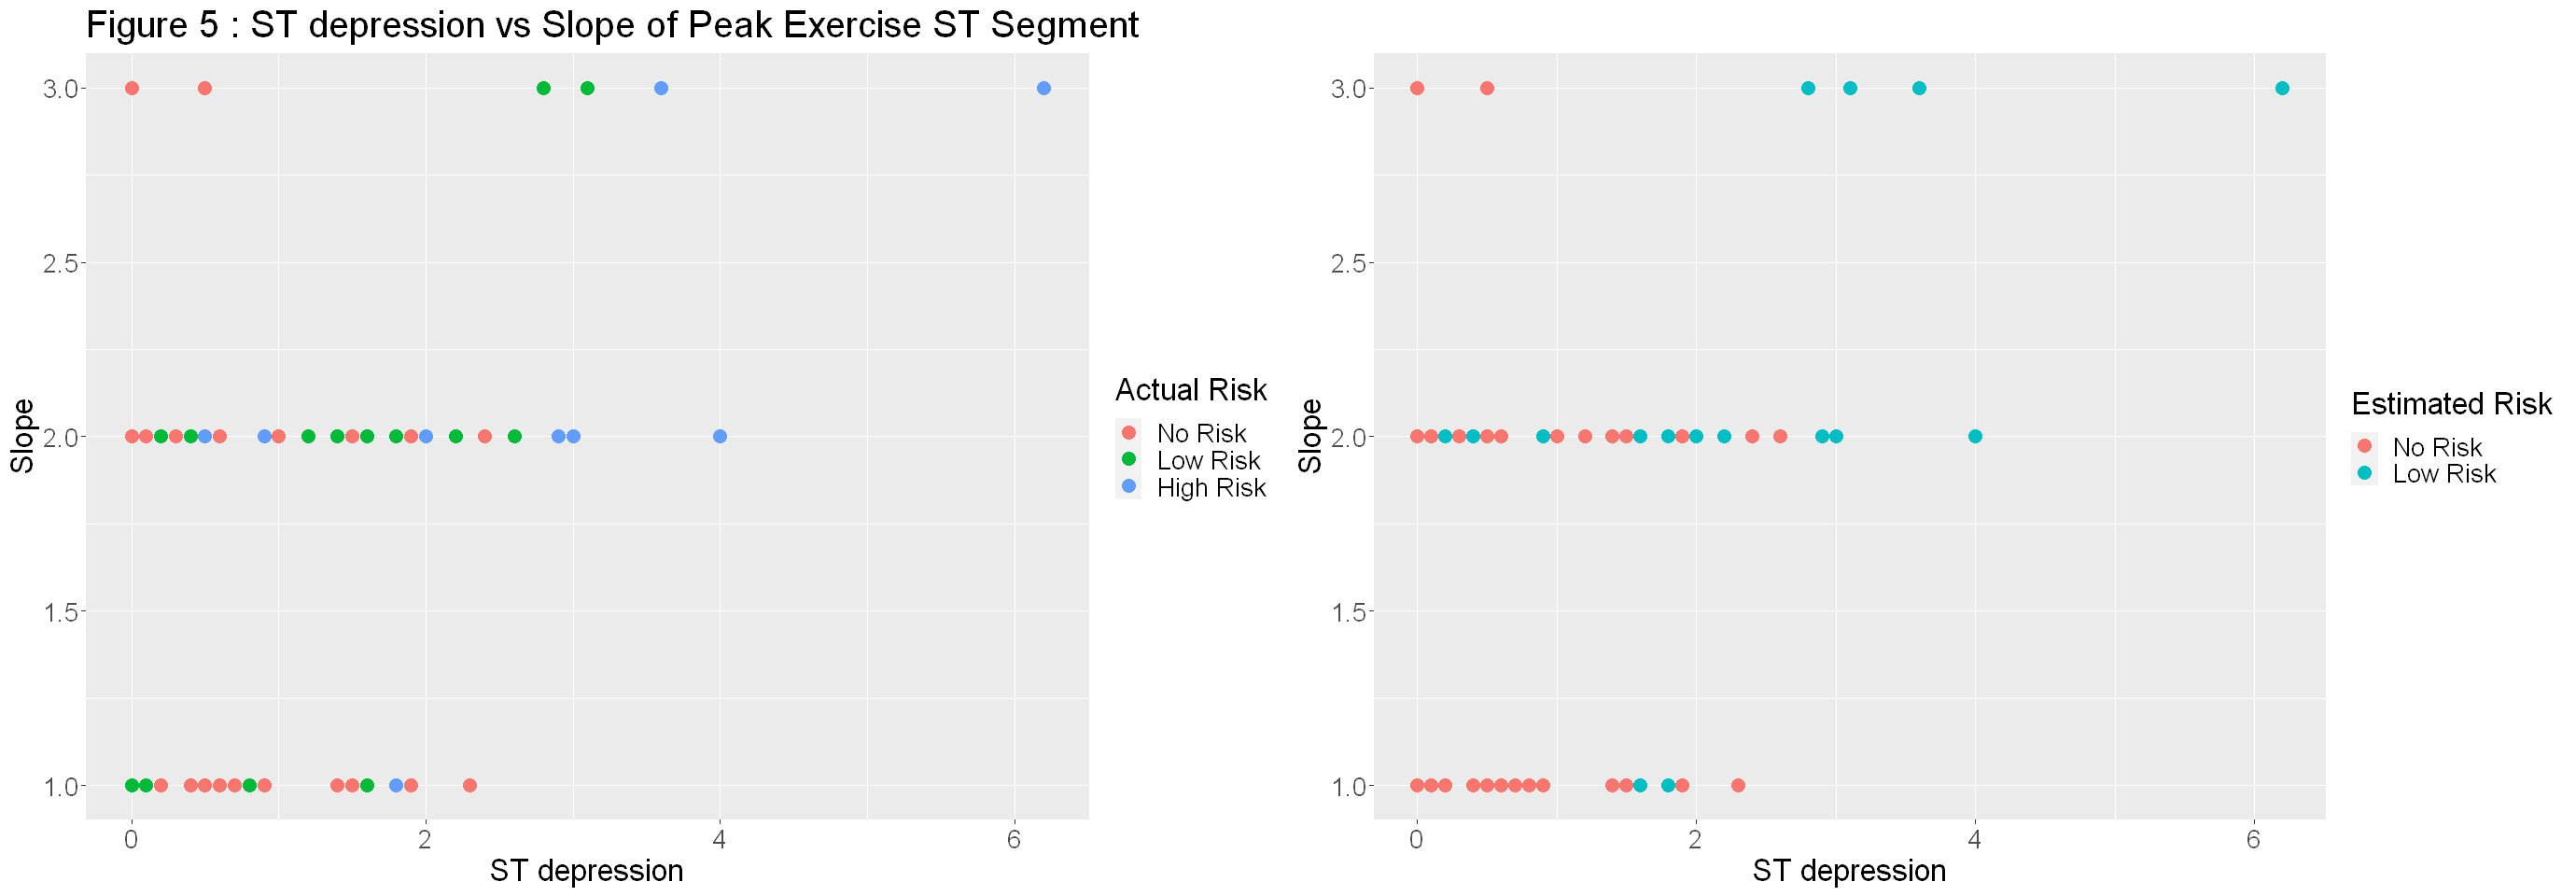

In [25]:
hd_pred_truth_slst <- hd_predictions |>
    ggplot(aes(x = st_depression, y = slope, color = risk)) +
    geom_point(size = 4) +
    labs(x = "ST depression", y = "Slope", color = "Actual Risk") +
    ggtitle("Figure 5 : ST depression vs Slope of Peak Exercise ST Segment") +
    theme(text = element_text(size = 20))

hd_pred_estimate_slst <- hd_predictions |>
    ggplot(aes(x = st_depression, y = slope, color = .pred_class)) +
    geom_point(size = 4) +
    labs(x = "ST depression", y = "Slope", color = "Estimated Risk") +
    ggtitle("") +
    theme(text = element_text(size = 20))

plot_grid(hd_pred_truth_slst, hd_pred_estimate_slst)

Figure 5, like Figure 4, concurs with the information from Table 5. There are no estimates of high risk, and were instead classified to be low risk. Overall, Figures 4 and 5 solidify the findings in Table 5, where the model can predict presence vs. absence of heart disease more accurately than the specific categories of risk.

 Looking back to the initial data exploration in Figure 1 and in Table 3, the means for some variables differed, but not many of the variables showed strong correlations to the level of risk. Even when there was somewhat of a trend between a given variable and the different risk levels, there was still a significant amount of overlap between risk levels. Certain values could easily be attributed to multiple different risk levels. This may have contributed to the relatively low accuracy of the classification model. Given the data set, it is difficult to classify risk level since there is so much overlap between categories. The data reflects that two different patients may have very similar health data, but could be in different risk categories. This may be due to environmental factors, genetics or individual biology.
 
  In a medical setting, this degree of accuracy would likely not be acceptable. Higher accuracy predictions would have to be made in order to be used on patients, as it is concerning the health of real individuals. If a patient that is actually high risk is classified as low risk, this may impact their decisions moving forward, their treatment, and their overall health. Analysis with additional variables, or a different method of analysis may yield more accurate prediction results. Additionally, an increased sample size from more locations may provide better training data that would result in more accurate predictions and allow the model to be used on patients outside of Cleveland. More health data from patients classed as high risk might improve the accuracy since there would be more neighbors for the model to use in its classification. This analysis prompts questions such as: What is the best health variable to classify heart disease risk? This could be explored with further data and analysis. 


## 4. Works Cited

About heart disease. Centers for Disease Control and Prevention. (2022, July 12). Retrieved …March 2, 2023, from https://www.cdc.gov/heartdisease/about.htm 

Robert, D. Heart Disease Data Set. UCI Machine Learning Repository. Retrieved March 2, …2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Rowden, A. (July, 2022). St depression on ECG: What it means and causes. Medical News …Today. from https://www.medicalnewstoday.com/articles/st-depression-on-ecg 

U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? U.S. Health …Care from a Global Perspective, 2019 | Commonwealth Fund. (2020, January 30). Retrieved …March 2, 2023, from …https://www.commonwealthfund.org/publications/issue-briefs/2020/jan/us-health-care-global-p…erspective-2019#:~:text=More%20than%20one%2Dquarter%20of,less%20in%20all%20other…%20countries 
